# calculate absolute vorticity from S2S data
## for use of calculating TC genesis potential index

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import metpy.calc as mpcalc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import xarray as xr
import dask

In [2]:
dsu = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_ua850_week2_monclim.nc')
dsu

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, member: 10, month: 12)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ua_850   (month, member, lat, lon) float32 ...

In [4]:
dsv = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_va850_week2_monclim.nc')
dsv

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, member: 10, month: 12)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    va_850   (month, member, lat, lon) float32 ...

In [6]:
dsu.ua_850.attrs['units']='m/s'
dsv.va_850.attrs['units']='m/s'

In [7]:
lon = dsu['lon'].data
lat = dsu['lat'].data


In [8]:
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)


In [9]:
latlon2d = xr.broadcast(dsu.lat, dsu.lon)

In [10]:
month_list=[]
for im in np.arange(0,12):
    member_list=[]
    for member in np.arange(0,10):
        vort_member = mpcalc.absolute_vorticity(dsu.ua_850[im, member,:,:], dsv.va_850[im, member,:,:], dx, dy, latlon2d[0] * units.degrees)
        member_list.append(vort_member)
    vort_member = xr.concat(member_list, "member")
    month_list.append(vort_member)
ds_vort = xr.concat(month_list, "month")


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid

In [11]:
ds_vort[0,0,:,:]

Magnitude,[[nan nan nan ... nan nan nan] [-0.00016526289561814297 -0.0001648920888045594 -0.00016441328450859865 ... -0.00016749578434036345 -0.00016700027113233362 -0.0001665700673675988] [-0.0001592049597489284 -0.0001587545129983092 -0.0001582905702487478 ... -0.0001608996077452576 -0.00016040119217942806 -0.0001599002458116301] ... [0.00015151787303838406 0.00015138767783983695 0.00015125218147288126 ... 0.00015195746808210482 0.00015183227514513575 0.00015170399497533215] [0.00015990516970999742 0.00015965232759425734 0.00015939124047257845 ... 0.00016074764233413853 0.00016050511656302006 0.0001602605973705127] [nan nan nan ... nan nan nan]]
Units,1/second


Text(0.0, 1.0, '500-hPa NAM Geopotential Heights (m) and Wind Barbs (kt)')

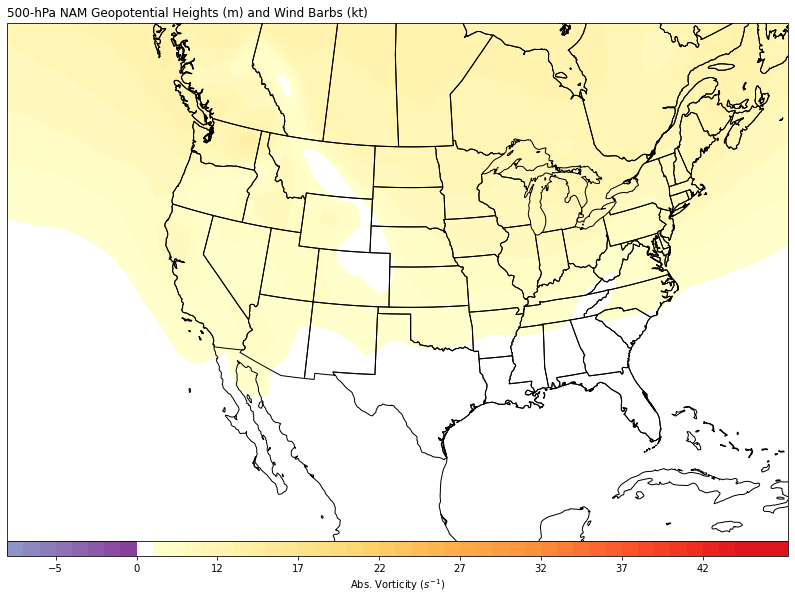

In [13]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Absolute Vorticity colors
# Use two different colormaps from matplotlib and combine into one color set
clevs_500_avor = list(range(-8, 1, 1))+list(range(8, 46, 1))
colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 48))
colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
colors = np.vstack((colors2, (1, 1, 1, 1), colors1))

# Plot absolute vorticity values (multiplying by 10^5 to scale appropriately)
cf = ax.contourf(latlon2d[1], latlon2d[0], ds_vort[1,0,:,:]*1e5, clevs_500_avor, colors=colors, extend='max',
                 transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)
cb.set_label('Abs. Vorticity ($s^{-1}$)')


# Set up a 2D slice to reduce the number of wind barbs plotted (every 20th)
wind_slice = (slice(None, None, 20), slice(None, None, 20))
#ax.barbs(lat2d[1][wind_slice], lat2d[0][wind_slice],
#         dsu.ua_850[9,0,:,:][wind_slice].data, dsv.va_850[9,0,:,:][wind_slice].data,
#         pivot='middle', color='black', transform=datacrs)

# Plot two titles, one on right and left side
plt.title('500-hPa NAM Geopotential Heights (m)'
          ' and Wind Barbs (kt)', loc='left')


In [14]:
ds_vort.to_dataset(name='vo').to_netcdf('/glade/scratch/huili7/S2S_data/S2S_vor850_week2_monclim.nc')